# Проект: Обучение с учителем: качество модели

## Введение


### Описание проекта

В работе исследуются данные о пользователях интернет-магазина "В один клик". Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Требуется разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. 


### Цели исследования

Необходимо выполнить анализ предоставленных данных и разработать прогнозные модели машинного обучения. Из разработанных моделей необходимо выбрать лучшую и на основе результатов ее работы определить способы повышения покупательской активности.

### План работы

- **Загрузка данных** - выполняется импорт необходимых библиотек, загрузка исходных данных;

- **Предобработка данных** - устраняются дубликаты, пропуски, ошибки в данных;

- **Исследовательский анализ данных** - выполняется анализ предоставленной информации - выявляются основные зависимости и распределения в данных;

- **Объединение таблиц** - требуется выполнить объединение трех таблиц в одну общую;

- **Корреляционный анализ** - на данном этапе определяется корреляция между входными признаками в исходных данных. В случае необходимости, устраняется мультиколлинеарность;

- **Использование пайплайнов** - с помощью пайплайнов перебирается несколько различных моделей, подбираются оптимальные гиперпараметры, способы масштабирования и кодирования;

- **Анализ важности признаков** - с помощью наилучшей модели оценивается вклад каждого признака в итоговое предсказание модели;

- **Сегментация покупателей** - на основе предыдущего раздела выделяется группа пользователей, для которой проводится дополнительный анализ;

- **Общий вывод** - краткое описание проделанной работы и основные выводы.

## Загрузка данных

### Импорт библиотек python и загрузка исходных данных

Загрузка необходимых библиотек и модулей.

In [1]:
!pip install shap 

In [2]:
!pip install phik

In [3]:
!pip install scikit-learn==1.1

  Using cached scikit-learn-1.1.0.tar.gz (6.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [66 lines of output]
  Partial import of sklearn during the build process.
  setup.py:128: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
    from numpy.distutils.command.build_ext import build_ext  # noqa
  INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  Traceback (most recent call last):
    File "C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
   

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import traceback
import seaborn as sns
import re
import shap
import phik

from scipy import stats as st

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

# билбилотеки для определения мультиколлинеарности
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split

# метрики
from sklearn.metrics import roc_auc_score

# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# дополнительные классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

# класс для работы с пропусками
from sklearn.impute import SimpleImputer 

from phik.report import plot_correlation_matrix
from phik import report, resources

# для отключения предупреждений
from warnings import simplefilter

# загружаем класс "цвет" для использования при форматировании текста
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

pd.set_option('display.float_format', '{:,.2f}'.format) # корректировка вывода чисел до точности двух знаков после запятой

# sns.set(style="ticks")
# sns.set_style("darkgrid")

Загрузка исходных данных в формат DataFrame.

In [75]:
market_file = pd.read_csv('C:/Users/Muziukin-DG/Python projects/Supervised-learning_v2/market_file.csv')
market_money = pd.read_csv('C:/Users/Muziukin-DG/Python projects/Supervised-learning_v2/market_money.csv')
market_time = pd.read_csv('C:/Users/Muziukin-DG/Python projects/Supervised-learning_v2/market_time.csv')
money = pd.read_csv('C:/Users/Muziukin-DG/Python projects/Supervised-learning_v2/money.csv', sep=';', decimal=',') # предварительный анализ файла показал, что в качестве
# разделителя столбцов нужно использовать символ ';', в качестве разделителя дробной части ','

### Раздел с собственными функциями

В данном разделе содержатся собственные функции, которые используются в проекте.

In [76]:
def data_analysis_cat(df):
    """Функция визуализирует категориальные данные датафрейма df в виде круговых диаграмм."""
    try:
        
        object_columns = df.select_dtypes(exclude='number').columns.tolist()
        
        print('Общие категориальные характеристики датафрейма:')
        display(df[object_columns].describe(include=[object]).T)
        print()
        print(f'Число категориальных признаков в датафрейме: {len(object_columns)}')
        print()
        num_of_rows = int(np.ceil(len(object_columns) / 2))
        
        if num_of_rows==1: # вывод графиков в случае, если в датафрейме только один столбец с категориальными данными
            for col in object_columns:
                fig, ax =plt.subplots(figsize=(6, 7))
                ax.pie(df[col].value_counts(), autopct='%.0f%%', labels = df[col].unique(),
                           colors=sns.color_palette('pastel')) 
                ax.set_title(f'Распределение данных\n в столбце "{col}"')
                plt.suptitle('Графическое представление категориальных данных', ha='center', fontsize='xx-large')
                plt.show()
        else: # вывод графиков в случае, если в датафрейме больше одного столбца с категориальными данными
            num_of_cols = 2
            fig, ax =plt.subplots(num_of_rows, num_of_cols, figsize=(12, 12), sharex='all', sharey='all')
            i = 0
            j = 0
            for col in object_columns:
                ax[i, j].pie(df[col].value_counts(), autopct='%.0f%%', labels = df[col].unique(),
                           colors=sns.color_palette('pastel')) 
                ax[i, j].set_title(f'Распределение данных\n в столбце "{col}"')
                if j == num_of_cols-1:
                    i += 1
                    j = 0
                else:
                    j +=1
            plt.suptitle('Графическое представление категориальных данных', ha='center', fontsize='xx-large')
            plt.show()
        
    except Exception:
        traceback.print_exc()

In [77]:
plt.rcParams['figure.constrained_layout.use'] = True # команда, чтобы графики не накладывались друг на друга

def data_analysis_num(df, bins=50, min_max=(0, 0)):
    """Функция визуализирует количественные данные датафрейма df. 
    Переменная bins - число корзин для гистограмм.
    Переменная min_max - кортеж, который принимает границы минимума и максимума по оси Ох для графиков."""
    try:
        numeric_columns = df.select_dtypes(include='number').columns.tolist()
        
        print(f'Общие числовые характеристики датафрейма:')
        display(df[numeric_columns].describe().T)
        print()
        print(f'Число количественных признаков в датафрейме: {len(numeric_columns)}')
        print()
        num_of_rows = int(len(numeric_columns))
        num_of_cols = 2
        figsize=(12, 5.3*num_of_rows) # расчет масшатаба графика. Коэффициенты подобраны вручную
        fig, ax =plt.subplots(num_of_rows, num_of_cols, figsize=figsize)
        
        
        if num_of_rows==1: # вывод графиков в случае, если в датафрейме только один столбец с категориальными данными
            for col in numeric_columns:
                g = sns.histplot(df[col], bins=bins, ax=ax[0], kde=True)
                if min_max!=(0,0):
                    g.set(xlim=min_max)
                g.set(xlabel=f'Значения столбца "{col}"', ylabel=f'Частота встречаемости',
                  title=f'Распределение данных\n в столбце "{col}"')
                g = sns.boxplot(x=df[col], showmeans=True, ax=ax[1], width=0.25)
                g.set(title=f'Диаграмма разброса данных\n в столбце "{col}"')
                if min_max!=(0,0):
                    g.set(xlim=min_max)
                
        else: # вывод графиков в случае, если в датафрейме больше одного столбца с категориальными данными
            i = 0
            for col in numeric_columns:
                g = sns.histplot(df[col], bins=bins, ax=ax[i, 0], kde=True)
                if min_max!=(0,0):
                    g.set(xlim=min_max)
                g.set(xlabel=f'Значения столбца "{col}"', ylabel=f'Частота встречаемости',
                  title=f'Распределение данных\n в столбце "{col}"')
                g = sns.boxplot(x=df[col], showmeans=True, ax=ax[i, 1], width=0.25)
                g.set(title=f'Диаграмма разброса данных\n в столбце "{col}"')
                if min_max!=(0,0):
                    g.set(xlim=min_max)
                i += 1
        plt.suptitle('Гистограммы распределения и диаграммы разброса числовых данных', ha='center', fontsize='xx-large')      
        plt.show()
    except Exception:
        traceback.print_exc()

In [78]:
def prepare_data(X_train, X_test, scaler=StandardScaler(), ohe=OneHotEncoder(sparse=False, drop='first')):
    '''Функция принимает на вход обучающую и тестовую выборки X, производит их кодирование и масштабирование.
    На выходе функция возвращает данные выборки зхакодированными и отмасштабированными.
    Возможно указать методы масшатабирования и кодирования.'''
    # списки с количественными и категориальными признаками
    cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
    num_col_names = X_train.select_dtypes(include='number').columns.tolist()
       
    # обучение и преобразование данных для обучающей и тестовой выборок 
    X_train_ohe = ohe.fit_transform(X_train[cat_col_names])
    X_test_ohe = ohe.transform(X_test[cat_col_names])
    
    # масштабирование количественных признаков в тренировочной и тестовой выборках 
    X_train[num_col_names] = scaler.fit_transform(X_train[num_col_names])
    X_test[num_col_names] = scaler.transform(X_test[num_col_names])
    
    # сохраняем в переменной encoder_col_names список названий новых столбцов 
    encoder_col_names = ohe.get_feature_names()
    
    # создаём датафрейм из закодированных данных
    # передаём названия столбцов из переменной encoder_col_names
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    # обнуляем индексы строк перед объединением количественных и категориальных 
    # признаков в датафрейм
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()

    # объедините количественные и категориальные признаки для тренировочного
    # и тестового датасетов
    X_train = pd.concat([X_train[num_col_names], X_train_ohe], axis=1)
    X_test = pd.concat([X_test[num_col_names], X_test_ohe], axis=1)
    
    return X_train, X_test

### Обзор загруженных данных

Выведем первые пять строк каждого датафрейма:

In [79]:
# в данном словаре будем хранить названия и ссылки на исходные датафреймы, чтобы иметь возможность 
# быстрого обращения к ним в цикле
df_dict = {
    'market_file': market_file,
    'market_money': market_money,
    'market_time': market_time,
    'money': money
}

for df_name in df_dict.keys():
    print(f'Первые пять строк датафрейма {color.BOLD}{df_name}{color.END}:')
    display(df_dict[df_name].head())
    print()

Первые пять строк датафрейма market_file:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2



Первые пять строк датафрейма market_money:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"



Первые пять строк датафрейма market_time:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Первые пять строк датафрейма money:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Выведем общую информацию о каждом датафрейме:

In [80]:
for df_name in df_dict.keys():
    print(f'{color.BOLD}Общая информация о датафрейме {df_name}{color.END}:')
    df_dict[df_name].info()
    print()

Общая информация о датафрейме market_file:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   

Анализ общей информации о каждом датафрейме показал следующее:
- ни в одном из датафреймов нет пропусков;
- нет необходимости в изменении типа данных в каком-либо столбце;
- во всех датафреймах необходимо привести названия столбцов к змеиному стилю - заменить пробел на нижнее подчеркивание, перевести все символы в нижний регистр. Перевод с кириллицы на латиницу не требуется, согласно заданию.

Приведем названия столбцов к змеиному стилю и повторно выведем каждый датафрейм:

In [81]:
for df_name in df_dict.keys():
    df = df_dict[df_name]
    df.columns = [re.sub(r' ', '_', i).lower() for i in df.columns]
    print(f'{color.BOLD}Первые пять строк датафрейма {df_name}{color.END}:')
    display(df.head())
    print()


Первые пять строк датафрейма market_file:


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2



Первые пять строк датафрейма market_money:


,id,период,выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"



Первые пять строк датафрейма market_time:


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Первые пять строк датафрейма money:


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Выводы по разделу

Выполнена загрузка исходных данных в четыре таблицы DataFrame:

- `market_file` - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
- `market_money` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
- `market_time` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода;
- `money` - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Анализ общей информации о каждом датафрейме показал, что во всех четырех **отсутствуют пропущенные значения**. Изменение типа данных столбцов **не требуется.** Выполнено приведение названия заголовков к змеиному стилю.

##  Предобработка данных

### Анализ уникальных значений

Предварительный обзор исходных данных показал, что некоторые столбцы целесообразно проверить на уникальные значения. К таким столбцам можно отнести те, которые содержат строковые данные. Выведем уникальные значения каждого такого столбца каждого датафрейма.

In [82]:
for df_name in df_dict.keys():
    df = df_dict[df_name]
    object_columns = df.select_dtypes(exclude='number').columns.tolist() # запишем в эту переменную названия столбцов с не числовыми данными
    if not object_columns:
        print(f'Датафрейм {color.BOLD}{df_name}{color.END} не содержит строковых данных.')
    else:
        print(f'Датафрейм {color.BOLD}{df_name}{color.END}:')
        print()
        for col in object_columns:
            print(f'Уникальные значения столбца {color.BOLD}{col:<30}{color.END}: {df[col].unique()}')
            print()

Датафрейм market_file:

Уникальные значения столбца покупательская_активность     : ['Снизилась' 'Прежний уровень']

Уникальные значения столбца тип_сервиса                   : ['премиум' 'стандартт' 'стандарт']

Уникальные значения столбца разрешить_сообщать            : ['да' 'нет']

Уникальные значения столбца популярная_категория          : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Датафрейм market_money:

Уникальные значения столбца период                        : ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Датафрейм market_time:

Уникальные значения столбца период                        : ['текущий_месяц' 'предыдцщий_месяц']

Датафрейм money не содержит строковых данных.


Из полученных результатов видно, что в таблице `market_file` в столбце `тип_сервиса` есть неявные дубли - значения `стандартт` необходимо заменить на `стандарт`. В таблице `market_time` в столбце `период` необходимо исправить значения `предыдцщий_месяц` на `предыдущий_месяц`.

Дополнительно проведем проверку на отсутствие повторов `id` в датафреймах - сравним между собой число уникальных значений `id` с общим числом строк в каждом датафрейме:

In [83]:
for df_name in df_dict.keys():
    df = df_dict[df_name]
    n_id = df['id'].nunique()
    print(f'Количество уникальных значений в поле {color.BOLD}{"id"}{color.END} датафрейма {color.BOLD}{df_name}{color.END}: {n_id}')
    print(f'Количество строк датафрейма {color.BOLD}{df_name}{color.END}: {df.shape[0]}')
    print()

Количество уникальных значений в поле id датафрейма market_file: 1300
Количество строк датафрейма market_file: 1300

Количество уникальных значений в поле id датафрейма market_money: 1300
Количество строк датафрейма market_money: 3900

Количество уникальных значений в поле id датафрейма market_time: 1300
Количество строк датафрейма market_time: 2600

Количество уникальных значений в поле id датафрейма money: 1300
Количество строк датафрейма money: 1300



Как видно из результатов, в датафреймах `market_money` и `money` отсутствуют дубли в поле `id`. При этом в двух других датафреймах число уникальных значений в три и два раза меньше числа строк. Это объясняется тем, что в датафрейме `market_money` каждый уникальный `id` встречается по три раза, а в датафрейме `market_time` - по два раза.

Чтобы проверить что в данных нет "левых" id, можно сравнить среднее арифметическое всех значений id в каждом датафрейме - если они совпадут, то это говорит нам о том, что никаких лишних значений в данных не оказалось.

In [84]:
for df_name in df_dict.keys():
    mean = df_dict[df_name]['id'].mean()
    print(f'Среднее значение id датафрейма {color.BOLD}{df_name}{color.END}: {mean}')

Среднее значение id датафрейма market_file: 215997.5
Среднее значение id датафрейма market_money: 215997.5
Среднее значение id датафрейма market_time: 215997.5
Среднее значение id датафрейма money: 215997.5


После выполненной проверки считаем, что поля `id` во всех датафреймах заполнены корректно.

### Корректировка неявных дубликатов

Выполним замену выявленных неявных дублей:

In [85]:
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

Проверяем, что после корректировки в датафреймах не появились пропуски:

In [86]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [87]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

Пропусков нет.

Выведем информацию об уникальных значениях обновленных датафреймов `market_file` (столбец `тип_сервиса`) и `market_time` (столбец `период`):

In [88]:
print(f'Уникальные значения столбца {color.BOLD}{"тип_сервиса"}{color.END} датафрейма {color.BOLD}{"market_file"}{color.END}:')
print(market_file['тип_сервиса'].unique())
print(f'Уникальные значения столбца {color.BOLD}{"период"}{color.END} датафрейма {color.BOLD}{"market_time"}{color.END}:')
print(market_time['период'].unique())

Уникальные значения столбца тип_сервиса датафрейма market_file:
['премиум' 'стандарт']
Уникальные значения столбца период датафрейма market_time:
['текущий_месяц' 'предыдущий_месяц']


Как видим, после выполненных преобразований неявных дублей в данных не осталось.

Также убедимся в том, что написание одинаковых значений в столбцах `период` датафреймов `market_money` и `market_time` совпадает.

In [89]:
market_time_unique_val = market_time['период'].unique().tolist()
print(market_time_unique_val)
market_money_unique_val = market_money['период'].unique().tolist()
print(market_money_unique_val)

if (market_time_unique_val[0] == market_money_unique_val[1]) and (market_time_unique_val[1] == market_money_unique_val[2]):
    print('Написания одинаковых значений совпадают')
else:
    print('Написания одинаковых не значений совпадают')

['текущий_месяц', 'предыдущий_месяц']
['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц']
Написания одинаковых значений совпадают


### Выявление явных дубликатов

Выполним проверку каждого датафрейма на явные дубликаты.

In [90]:
for df_name in df_dict.keys():
    print(f'Датафрейм {color.BOLD}{df_name}{color.END} содержит {color.BOLD}{df_dict[df_name].duplicated().sum()}{color.END} явных дубликатов.')

Датафрейм market_file содержит 0 явных дубликатов.
Датафрейм market_money содержит 0 явных дубликатов.
Датафрейм market_time содержит 0 явных дубликатов.
Датафрейм money содержит 0 явных дубликатов.


### Выводы по разделу

Выполнен анализ данных на наличие явных и неявных дублей. Выполнена корректировка неявных дублей в датафрейме `market_file` в столбце `тип_сервиса` и в датафрейме `market_time` в столбце `период`. Явных дублей в данных не было обнаружено. Выполнена проверка совпадения в написании одинаковых значений в разных датафреймах. Проверка показала корректное написание повтоярющихся значений.

Также анализ уникальных значений датафреймов `market_money` и `market_time` показал, что в последнем данные представлены только за текущий и предыдущий месяцы, в то время как в датафрейме `market_money` помимо прочего есть данные за препредыдущий месяц. Запомним этот момент, возможно он как-то повлияет на дальнейшее использование данных при обучении модели.

## Исследовательский анализ данных

С помощью ранее написанных функций выведем графики распределения данных в каждом датафрейме.

### Анализ данных в датафрейме market_file

Общие числовые характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,"1,300.00",4.25,1.01,0.90,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,"1,300.00",4.01,0.70,3.00,4.00,4.00,4.00,5.00
длительность,"1,300.00",601.90,249.86,110.00,405.50,606.00,806.00,"1,079.00"
акционные_покупки,"1,300.00",0.32,0.25,0.00,0.17,0.24,0.30,0.99
средний_просмотр_категорий_за_визит,"1,300.00",3.27,1.36,1.00,2.00,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,"1,300.00",2.84,1.97,0.00,1.00,3.00,4.00,10.00
ошибка_сервиса,"1,300.00",4.19,1.96,0.00,3.00,4.00,6.00,9.00
страниц_за_визит,"1,300.00",8.18,3.98,1.00,5.00,8.00,11.00,20.00



Число количественных признаков в датафрейме: 8



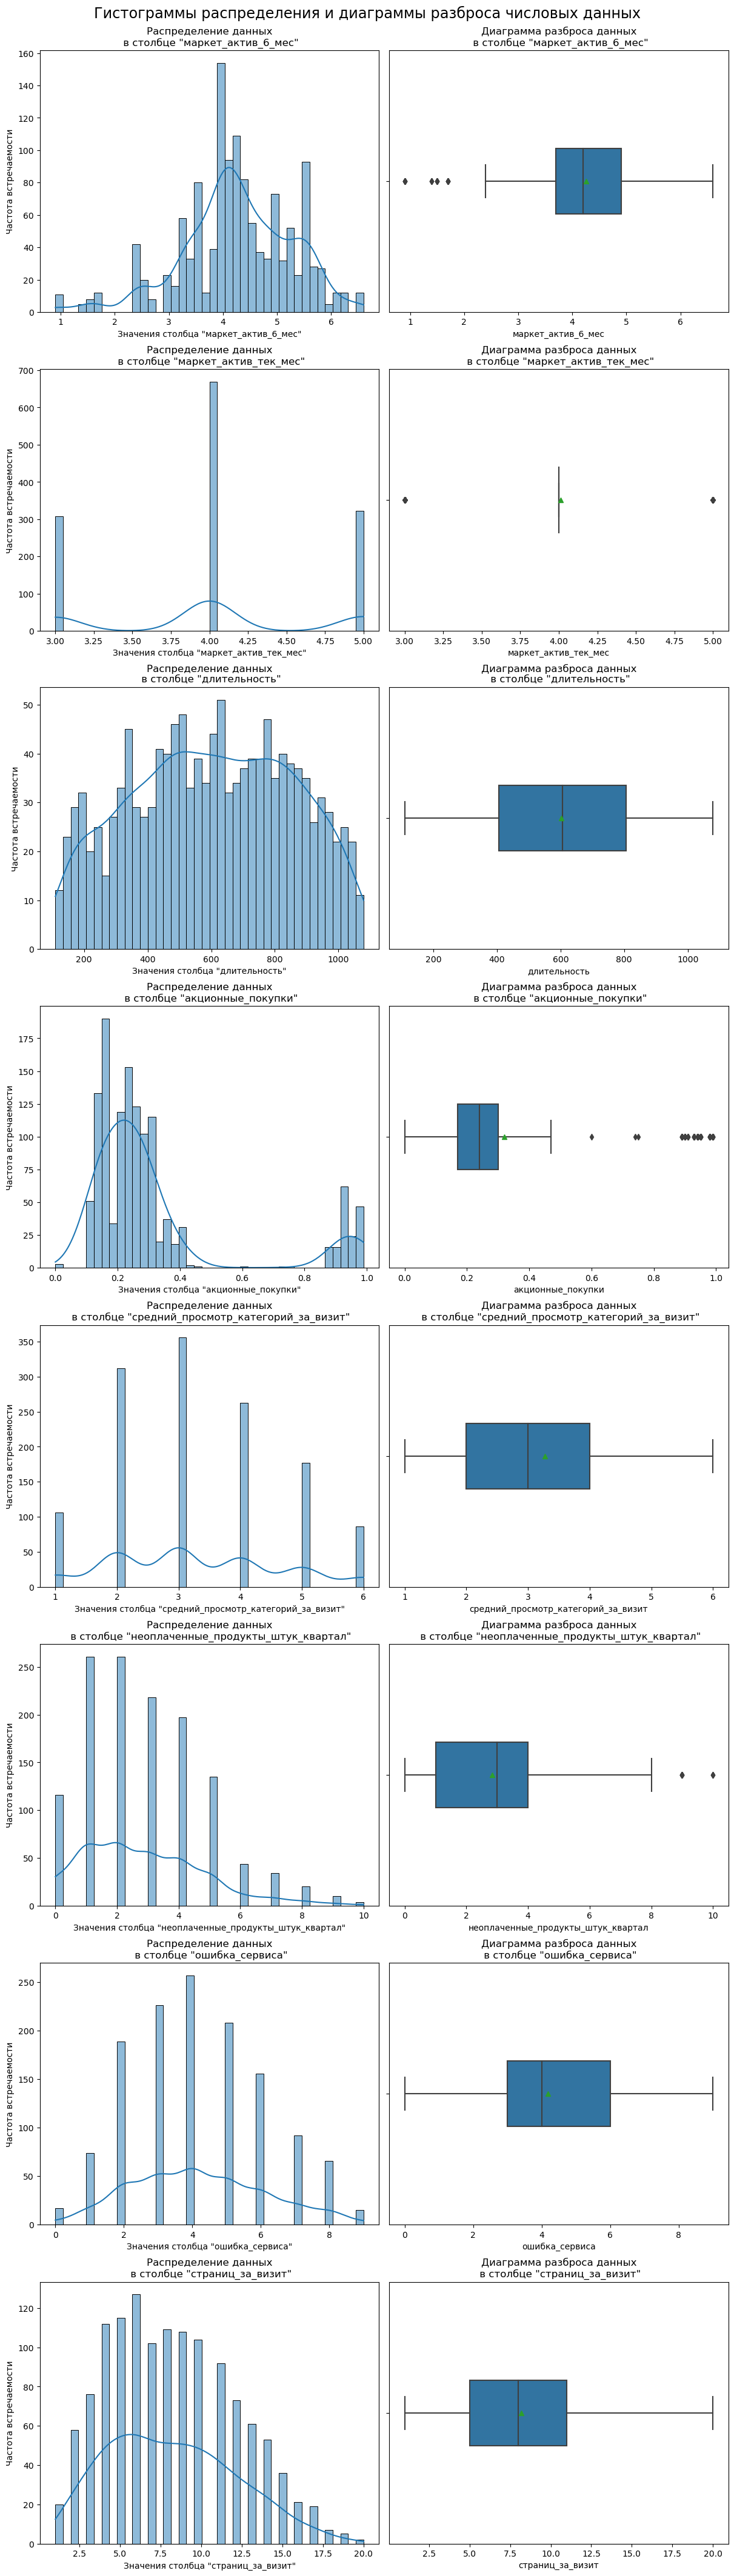

In [91]:
data_analysis_num(market_file.drop(columns='id'), 40)

**Предварительные выводы по количественным данным датафрейма `market_file`:**

- в столбце `маркет_актив_6_мес` распределение данных напоминает нормальное. При этом есть несколько выбросов в области минимальных значений;
- в столбце `маркет_актив_тек_мес` существует только три уникальных значения: 3, 4, 5. Чаще всего встречается значение 4. Остальные два встрчеаются реже примерно одинаковое число раз;
- в столбце `длительность` данные распределены равномерно, выбросов нет. Медиана и среднее практически совпадают - 606 и 602 дня соответсвтенно.
- в столбце `акционные_покупки` данные распределены неравномерно. Присутствуют два отдельных "колокола". Основной в диапазоне значений от 0.1 до 0.4. Второй в диапазоне от 0.9 до 1. Наличие второго "колокола" (выбросов) говорит нам о том, что среди покупателей на сайте есть достаточное количество тех, которые в основном совершают только акционные покупки;
- в столбце `средний_просмотр_категорий_за_визит` распределение данных напоминает распределение Пуассона. Выбросов нет;
- в столбце `неоплаченные_продукты_штук_квартал` распределение данных также напоминает распределение Пуассона. При этом есть два выброса в области максимальных значений;
- в столбце `ошибка_сервиса` распределение данных похоже на нормальное. Выбросов нет;
- в столбце `страниц_за_визит` распределение данных напоминает распределение Пуассона. Выбросов нет.



Общие категориальные характеристики датафрейма:


,count,unique,top,freq
покупательская_активность,1300,2,Прежний уровень,802
тип_сервиса,1300,2,стандарт,924
разрешить_сообщать,1300,2,да,962
популярная_категория,1300,6,Товары для детей,330



Число категориальных признаков в датафрейме: 4



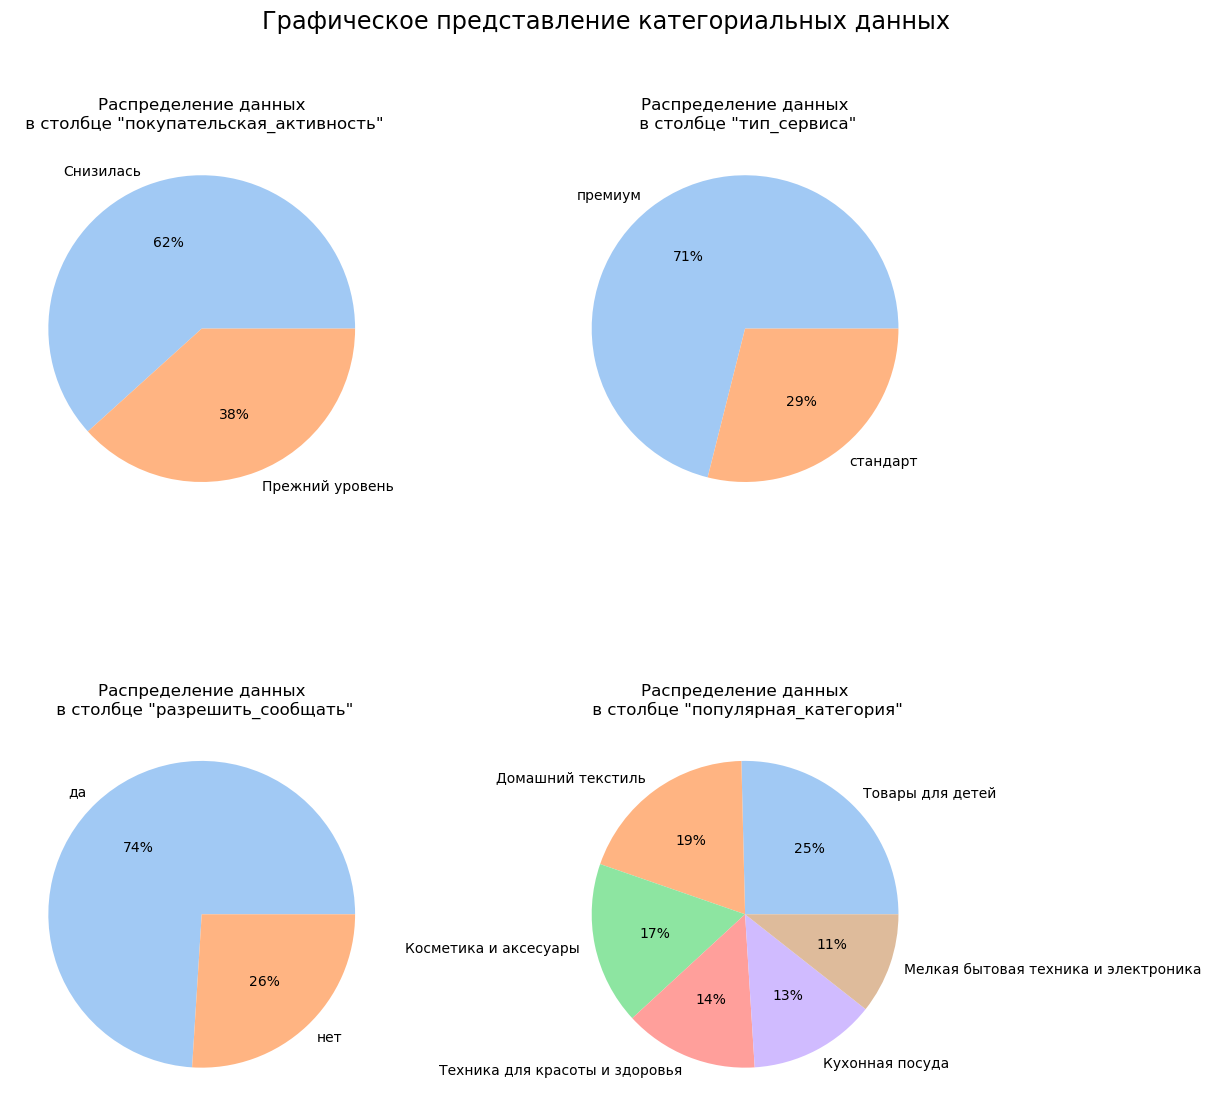

In [92]:
data_analysis_cat(market_file)

**Предварительные выводы по категориальным данным датафрейма `market_file`:**

- в столбце `покупательская_активность` 62% пользователей имеют сниженный уровень покупательской способности, а 38% - прежний уровень;
- в столбце `тип_сервиса` 71% пользователей имеют премиальный тип обслуживания, 29% - стандартный;
- в столбце `разрешить_сообщать` - 74% пользователей дали согласие на рассылку дополнительных предложений о товаре;
- в столбце `популярная_категория` самая популярная категория - "Товары для детей" (25%), далее следует "Домашний текстиль" (19%), "Косметика и аксесуары (17%). Остальные три категориии встречаются менее 15% каждая.

### Анализ данных в датафрейме market_money

Общие числовые характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
выручка,"3,900.00","5,025.70","1,777.70",0.00,"4,590.15","4,957.50","5,363.00","106,862.20"



Число количественных признаков в датафрейме: 1



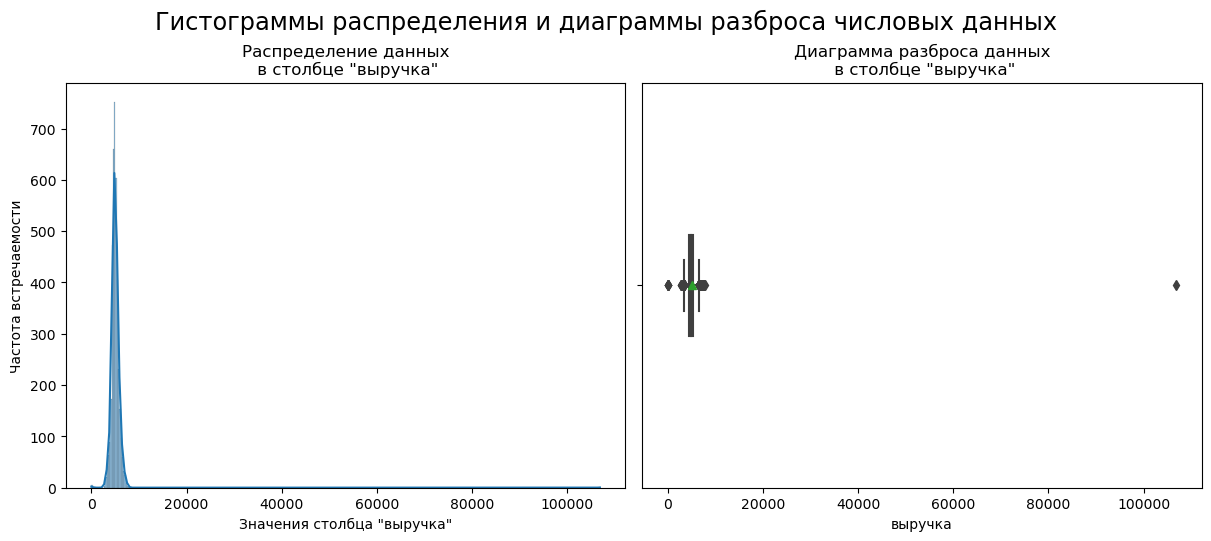

In [93]:
data_analysis_num(market_money.drop(columns='id'), 400)

При исользовании функции `data_analysis_num` график получился непоказательным из-за наличия выброса с большим значением. Повторно выведем распределение количественных данных без учета этого выброса за счет задания границы по оси абцисс:

Общие числовые характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
выручка,"3,900.00","5,025.70","1,777.70",0.00,"4,590.15","4,957.50","5,363.00","106,862.20"



Число количественных признаков в датафрейме: 1



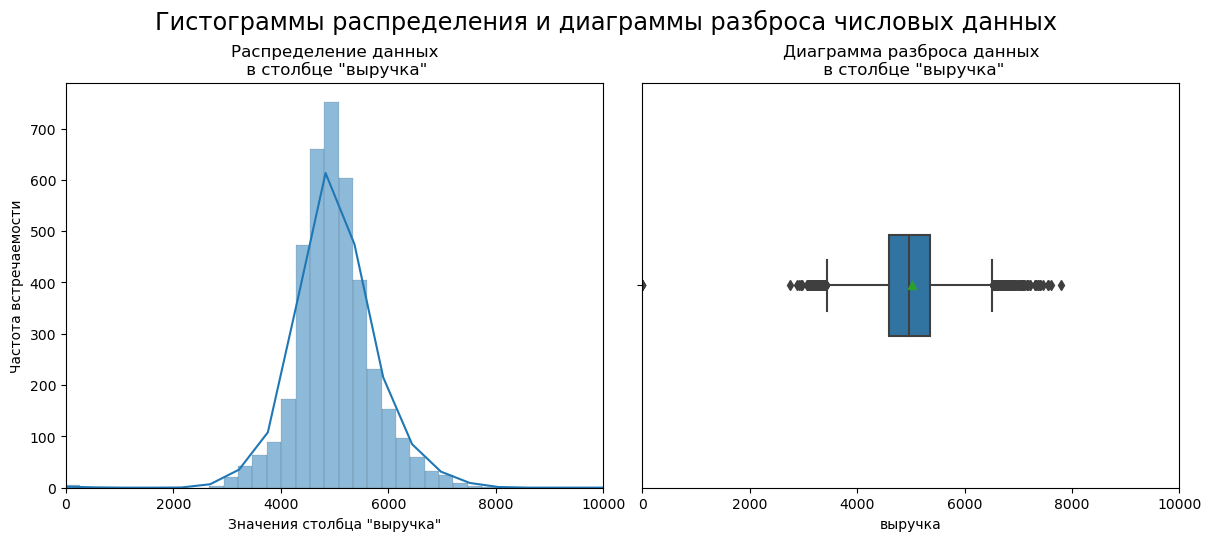

In [94]:
data_analysis_num(market_money.drop(columns='id'), 400, (0, 10000))

**Анализ выброса**

Проведем анализ выявленного выброса в данных. Сначала установим id, относящийся к выбросу:

In [95]:
id_max = market_money.loc[market_money['выручка'] > 10000]['id'].values[0]
market_money[market_money['выручка'] > 10000]

,id,период,выручка
98,215380,текущий_месяц,"106,862.20"


In [96]:
market_file[market_file['id'] == id_max]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,Снизилась,премиум,нет,1.70,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


**Предварительные выводы по количественным данным датафрейма `market_money`:**

- в столбце `выручка` распределение данных напоминает нормальное. Среднеее и медиана близки друг к другу: 5025 и 4590 соответственно. При этом есть выбросы с обоих сторон от среднего. Также обнаружен очень высокий одиночный выброс в данных величиной в 106862. Анализ смежной таблицы не показал каких-либо отклонений в данных, относящихся к id с этим выбросом. Скорее всего, данный выброс лучше всего скорректировать - заменить его медианным значением.

In [97]:
market_money.loc[market_money['выручка'] == 106862.20, 'выручка'] = market_money['выручка'].median()

Повторный анализ данных после корректировки выброса.

Общие числовые характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
выручка,"3,900.00","4,999.57",706.91,0.00,"4,590.15","4,957.25","5,363.00","7,799.40"



Число количественных признаков в датафрейме: 1



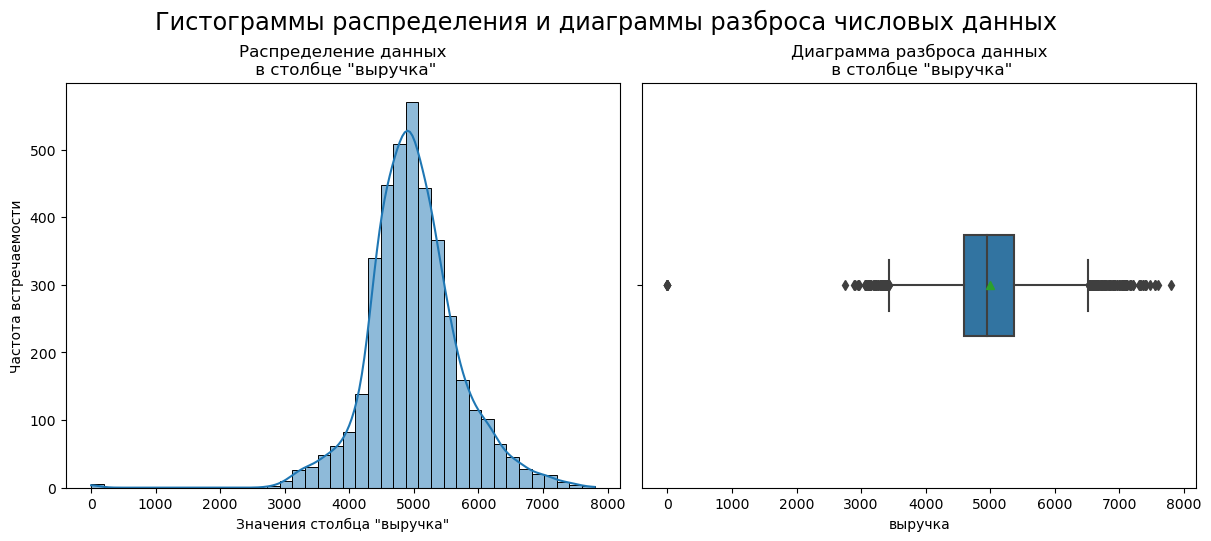

In [98]:
data_analysis_num(market_money.drop(columns='id'), 40)

Как видим, после корректировки общие характеристики данных улучшились. ~~При этом, выбросы со значением 0 нельзя убирать, так как они означают отсутствие покупок за конкретный период.~~

Среди пользователей есть те, у которых выручка хотя бы в одном месяце составила 0 рублей. Согласно заданию, такие клиенты не подходят для дальнейшего обучения модели и их требуется исключить из исходных данных.

Для этого создадим список, в который запишем `id` таких клиентов. В дальнейшем, данный список используем при объединении таблиц и подготовке итогового датафрейма перед обучением модели.

In [99]:
# новый код
id_to_exclude = list(market_money[market_money['выручка'] == 0]['id'].unique())
id_to_exclude

[215348, 215357, 215359]

Выполним повторный анализ без данных клиентов:

Общие числовые характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
выручка,"3,891.00","5,007.53",679.15,"2,758.70","4,592.00","4,959.00","5,363.00","7,799.40"



Число количественных признаков в датафрейме: 1



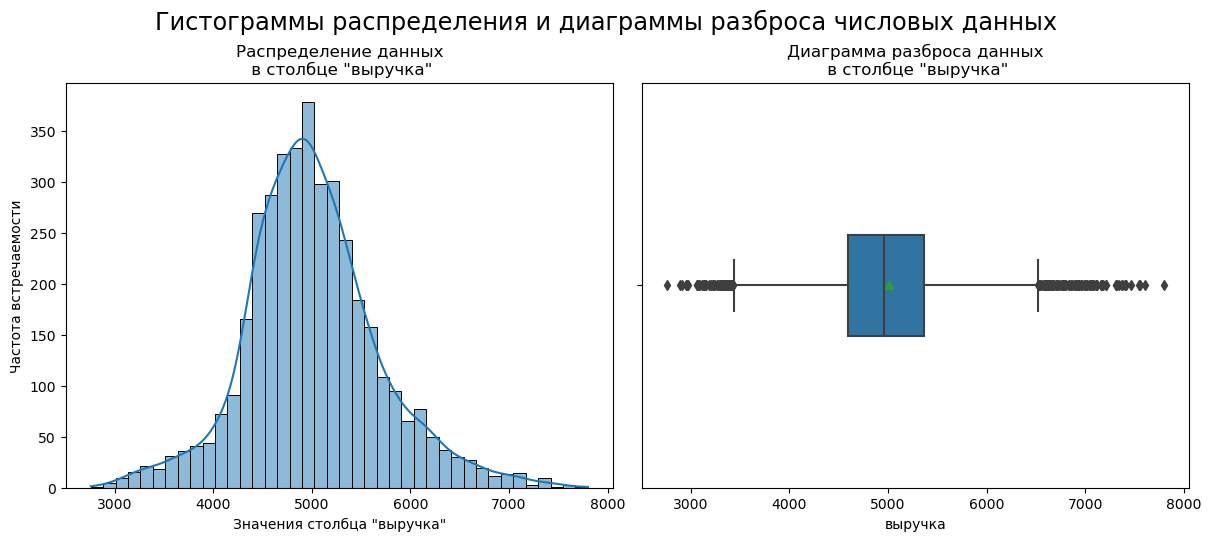

In [100]:
# новый код
data_analysis_num(market_money.query('id not in @id_to_exclude').drop(columns='id'), 40)

Теперь распределение выручки напоминает нормальное. Средняя выручка составляет 5007 руб.

Общие категориальные характеристики датафрейма:


,count,unique,top,freq
период,3891,3,препредыдущий_месяц,1297



Число категориальных признаков в датафрейме: 1



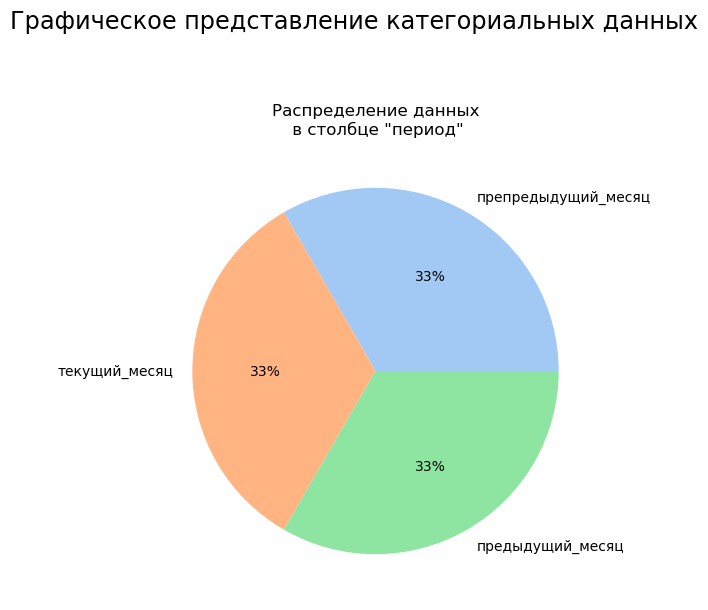

In [101]:
data_analysis_cat(market_money.query('id not in @id_to_exclude'))

**Предварительные выводы по категориальным данным датафрейма `market_money`:**

- столбец `период` содержит три уникальных значения. Их распределение одинаковое - по 33,3% от общего числа записей.

### Анализ данных в датафрейме market_time

Общие числовые характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
минут,"2,600.00",13.34,4.08,4.00,10.00,13.00,16.00,23.00



Число количественных признаков в датафрейме: 1



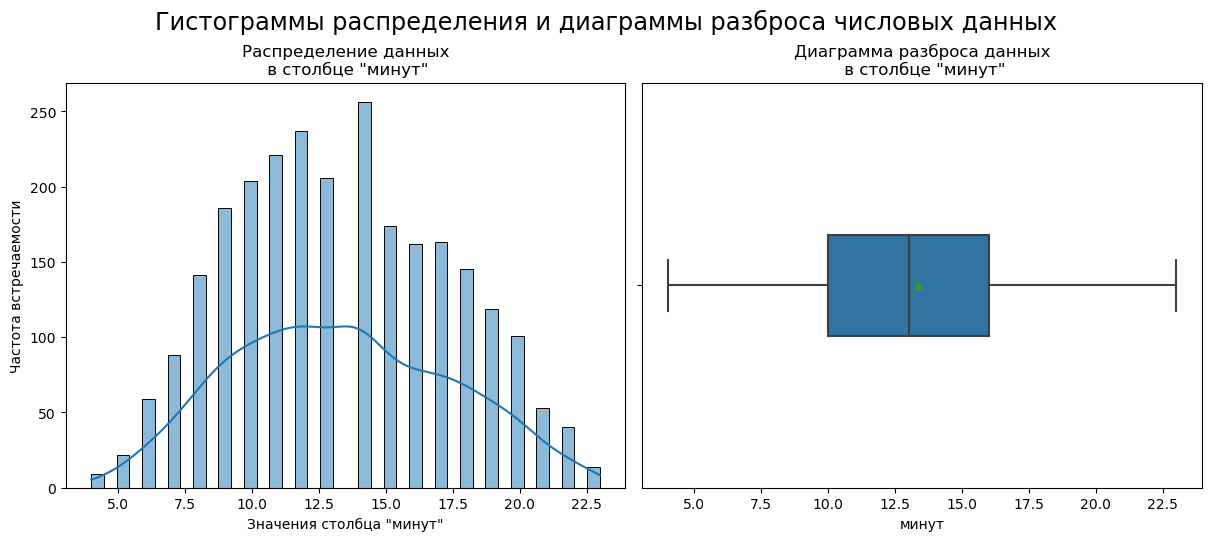

In [102]:
data_analysis_num(market_time.drop(columns='id'), 40)

**Предварительные выводы по количественным данным датафрейма `market_time`:**

- в столбце `выручка` распределение данных напоминает нормальное. Среднеее и медиана близки друг к другу: 13.34 и 13 соответственно. Выбросов нет.

Общие категориальные характеристики датафрейма:


,count,unique,top,freq
период,2600,2,текущий_месяц,1300



Число категориальных признаков в датафрейме: 1



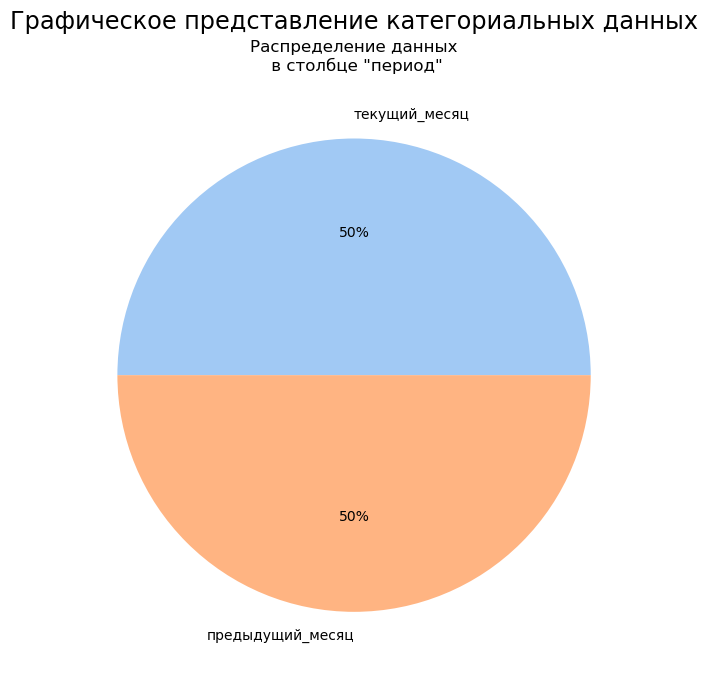

In [103]:
data_analysis_cat(market_time)

**Предварительные выводы по категориальным данным датафрейма `market_time`:**

- столбец `период` содержит два уникальных значения. Их распределение одинаковое - по 50% от общего числа записей.

### Анализ данных в датафрейме money

Общие числовые характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
прибыль,"1,300.00",4.00,1.01,0.86,3.30,4.04,4.67,7.43



Число количественных признаков в датафрейме: 1



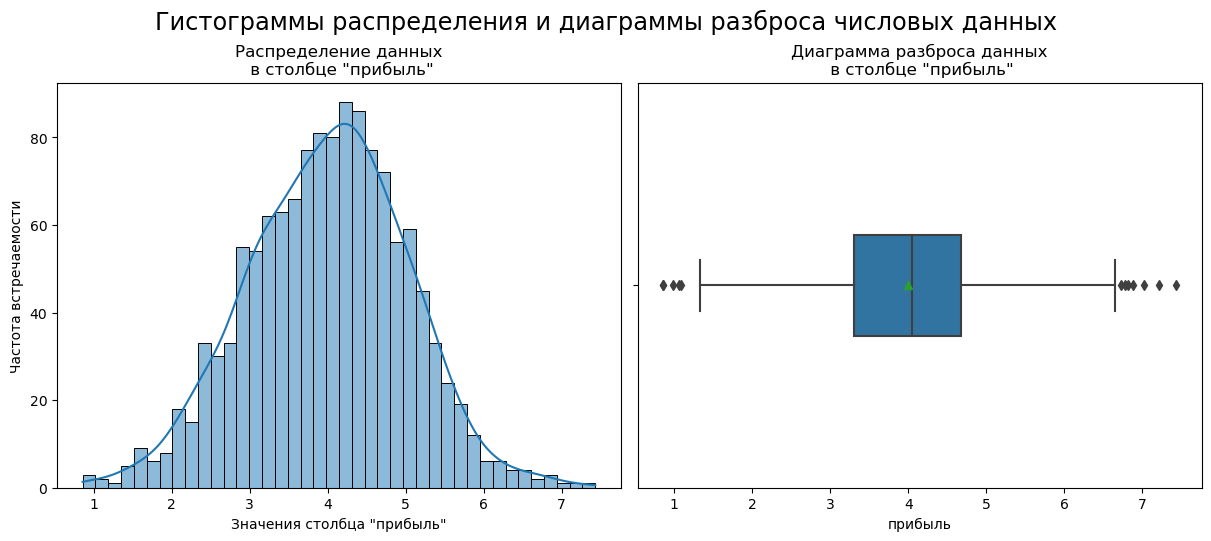

In [104]:
data_analysis_num(money.drop(columns='id'), 40)

**Предварительные выводы по количественным данным датафрейма `money`:**

- в столбце `прибыль` распределение данных напоминает нормальное. Среднеее и медиана близки друг к другу: 4 и 4.04 соответственно. Есть незначительные выбросы по обоим сторонам от распределения.

### Выводы по разделу

Наибольший объем данных представлен в датафрейме `market_file` - 8 количественных и 4 категориальных признака. Датафреймы `market_money` и `market_time` содержат по одному категориальному и количественному признаку. Таблица `money` содержит один количественный признак.

Анализ данных в датафрейме `market_file` показал следующее:
- большинство числовых данных не содержат выбросов, а их распределения напоминают нормальное или распределение Пуассона. Наибольшее число выбросов обнаружено в столбце `акционные_покупки`. Присутствуют два отдельных "колокола". Основной в диапазоне значений от 0.1 до 0.4. Второй в диапазоне от 0.9 до 1. Наличие второго "колокола" (выбросов) говорит нам о том, что среди покупателей на сайте есть достаточное количество тех, которые в основном совершают только акционные покупки;
- в столбце `покупательская_активность` 62% пользователей имеют сниженный уровень покупательской способности, а 38% - прежний уровень; в столбце `тип_сервиса` 71% пользователей имеют премиальный тип обслуживания, 29% - стандартный; в столбце `разрешить_сообщать` - 74% пользователей дали согласие на рассылку дополнительных предложений о товаре; в столбце `популярная_категория` самая популярная категория - "Товары для детей" (25%), далее следует "Домашний текстиль" (19%), "Косметика и аксесуары (17%). Остальные три категориии встречаются менее 15% каждая.

Анализ данных в датафрейме `market_money` показал наличие одиночного выброса в столбце `выручка`, значение которого сильно отличается от среднего и медианы (106862 против 5025 и 4590 соответственно). Данный выброс был заменен на медианное значение. В категориальных данных уникальные значения распределены одинаково. Также были выявлены три клиента с низкой покупательской активностью за последние три месяца. `id` данных клинетов занесены в отдельную переменную для дальнейшего исключения из данных для обучения и тестирования модели.

В датафрейме `market_time` выбросов не обнаружено, уникальные категориальные данные распределены одинаково.

В датафрейме `money` распределение данных близко к нормальному, присутствуют незначительные выбросы.


## Объединение таблиц

Необходимо выполнить слияние таблиц `market_file`, `market_money`, `market_time`. В качестве ключевого поля будет выступать `id`. Также при объединении необходимо распределить уникальные значения столбца `период` по отдельным столбцам итоговой таблицы.

### Подготовка таблиц к объединению
Предварительно исключим из всех четырех таблиц `id` клиентов с низкой покупательской способностью.

In [105]:
# новый код
def df_querry(df, clients):
    return df.query('id not in @clients')

In [106]:
# новый код
market_file = df_querry(market_file, id_to_exclude)
market_money = df_querry(market_money, id_to_exclude)
market_time = df_querry(market_time, id_to_exclude)
money = df_querry(money, id_to_exclude)

In [107]:
# новый код
df_dict = {
    'market_file': market_file,
    'market_money': market_money,
    'market_time': market_time,
    'money': money
}

for df_name in df_dict.keys():
    print(f'Размерность датафрейма {color.BOLD}{df_name}{color.END} после удаления клиентов с низкой покупательской способностью:')
    print(df_dict[df_name].shape)
    print()

Размерность датафрейма market_file после удаления клиентов с низкой покупательской способностью:
(1297, 13)

Размерность датафрейма market_money после удаления клиентов с низкой покупательской способностью:
(3891, 3)

Размерность датафрейма market_time после удаления клиентов с низкой покупательской способностью:
(2594, 3)

Размерность датафрейма money после удаления клиентов с низкой покупательской способностью:
(1297, 2)



Чтобы сформировать новые столбцы за каждый период, воспользуемся методом `pivot` применительно к датафреймам `market_money`, `market_time`:

In [108]:
market_money_pivot = market_money.pivot(index='id', columns='период')
market_money_pivot.head()

выручка                                  
период предыдущий_месяц препредыдущий_месяц текущий_месяц
id                                                       
215349         5,216.00            4,472.00      4,971.60
215350         5,457.50            4,826.00      5,058.40
215351         6,158.00            4,793.00      6,610.40
215352         5,807.50            4,594.00      5,872.50
215353         4,738.50            5,124.00      5,388.50

In [109]:
market_time_pivot = market_time.pivot(index='id', columns='период')
market_time_pivot.head()

минут              
период предыдущий_месяц текущий_месяц
id                                   
215349               12            10
215350                8            13
215351               11            13
215352                8            11
215353               10            10

У основной таблицы сделаем поле `id` индексом строк:

In [110]:
market_file = market_file.set_index('id')
market_file

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
id,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.60,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
216644,Прежний уровень,стандарт,нет,5.10,4,454,0.21,Домашний текстиль,6,2,3,9
216645,Прежний уровень,стандарт,да,4.10,3,586,0.20,Домашний текстиль,3,2,5,7


### Выполнение объединения

Выполняем объединение получившихся таблиц с основной:

In [111]:
market_data = pd.merge(market_file, market_money_pivot.droplevel(0, axis=1), left_index=True, right_index=True)
market_data = pd.merge(market_data, market_time_pivot.droplevel(0, axis=1), left_index=True, right_index=True)

In [112]:
market_money_pivot.columns.levels

FrozenList([['выручка'], ['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц']])

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green">Это предупреждение возникает, когда ты пытаешься объединить два DataFrame с разными уровнями индексов по столбцам. Один DataFrame имеет одномерный индекс (один уровень), а другой — многомерный (два уровня). При объединении Pandas не может гарантировать, что результат будет таким, как ты ожидаешь, поэтому и выдает предупреждение.\
Можно сбросить индексы у pivot таблиц и объединять по 'id', и затем переводить 'id' в индекс.</span>

Выполним переименование некоторых столбцов для дальнейшего удобства:

In [113]:
columns_to_rename = {
    ('выручка', 'предыдущий_месяц'): 'выручка_за_предыдущий_месяц',
    ('выручка', 'препредыдущий_месяц'): 'выручка_за_препредыдущий_месяц',
    ('выручка', 'текущий_месяц'): 'выручка_за_текущий_месяц',
    ('минут', 'предыдущий_месяц'): 'минут_в_предыдущем_месяце',
    ('минут', 'текущий_месяц'): 'минут_в_текущем_месяце'
}
market_data.rename(columns=columns_to_rename, inplace=True)

Итоговый вид получившейся таблицы:

In [114]:
market_data.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,"5,216.00","4,472.00","4,971.60",12,10
215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,"5,457.50","4,826.00","5,058.40",8,13
215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,"6,158.00","4,793.00","6,610.40",11,13
215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,"5,807.50","4,594.00","5,872.50",8,11
215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,"4,738.50","5,124.00","5,388.50",10,10


Размерность итоговой таблицы:

In [115]:
# новый код
market_data.shape

(1297, 17)

### Выводы по разделу

Выполнено объединение таблиц `market_file`, `market_money`, `market_time` в одну общую `market_data`. Получившаяся таблица имеет размерность ~~1300~~ 1297 на 17 после исключения клиентов с низкой покупательской активностью.

## Корреляционный анализ

В данном разделе необходимо выполнить корреляционный анализ признаков в количественной шкале в итоговой таблице `market_data`. В случае выявления мультиколлинеарности её необходимо устранить.

### Расчет коэффициентов корреляции

Выполним расчет коэффициентов корреляции датафрейма `market_data` с помощью встроенного метода `corr()`. В качестве расчетного метода будем использовать "spearman", так как в некоторых данных есть выбросы.

In [116]:
numeric_columns = market_data.select_dtypes(include='number').columns.tolist() # запишем в список только столбцы с числовыми данными
market_data[numeric_columns].corr(method='spearman').style.background_gradient(cmap='coolwarm')

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
маркет_актив_6_мес,1.000000,0.061697,-0.044614,-0.277968,0.185027,-0.134368,0.038656,0.319918,-0.005652,0.233325,0.002680,0.274003,0.226345
маркет_актив_тек_мес,0.061697,1.000000,-0.131979,0.033045,-0.025158,0.061754,0.087351,0.003144,-0.027107,-0.039397,-0.011758,0.013538,-0.063044
длительность,-0.044614,-0.131979,1.000000,0.029186,-0.043150,-0.108822,0.103528,-0.034591,0.013739,-0.039284,0.014968,-0.124000,0.083035
акционные_покупки,-0.277968,0.033045,0.029186,1.000000,-0.203380,0.197624,-0.051590,-0.370853,0.007035,-0.267790,0.021681,-0.332743,-0.274693
средний_просмотр_категорий_за_визит,0.185027,-0.025158,-0.043150,-0.203380,1.000000,-0.251448,0.010034,0.267536,-0.049596,0.149619,-0.070625,0.148376,0.233358
неоплаченные_продукты_штук_квартал,-0.134368,0.061754,-0.108822,0.197624,-0.251448,1.000000,-0.098544,-0.165297,0.032958,-0.249421,0.061280,-0.183426,-0.214803
ошибка_сервиса,0.038656,0.087351,0.103528,-0.051590,0.010034,-0.098544,1.000000,0.104508,0.035383,0.090105,0.040518,0.196017,0.078089
страниц_за_визит,0.319918,0.003144,-0.034591,-0.370853,0.267536,-0.165297,0.104508,1.000000,-0.067879,0.311428,-0.049886,0.450913,0.298113
предыдущий_месяц_x,-0.005652,-0.027107,0.013739,0.007035,-0.049596,0.032958,0.035383,-0.067879,1.000000,0.308707,0.877630,-0.084632,-0.082747
препредыдущий_месяц,0.233325,-0.039397,-0.039284,-0.267790,0.149619,-0.249421,0.090105,0.311428,0.308707,1.000000,0.149703,0.348403,0.299989


Анализ полученной таблицы показал, что наибольшая корреляция наблюдается между следующими числовыми признаками:

- `выручка_за_текущий_месяц` vs `выручка_за_предыдущий_месяц`: 0.88;
- `минут_в_предыдущем_месяце` vs `страниц_за_визит`: 0.45;

Также наблюдаются несколько пар признаков между которыми корреляция находится на уровне 0.3. У части параметров корреляция оказалось отрицательной: от -0.1 до -0.35.

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц_x', 'препредыдущий_месяц', 'текущий_месяц_x', 'предыдущий_месяц_y', 'текущий_месяц_y']


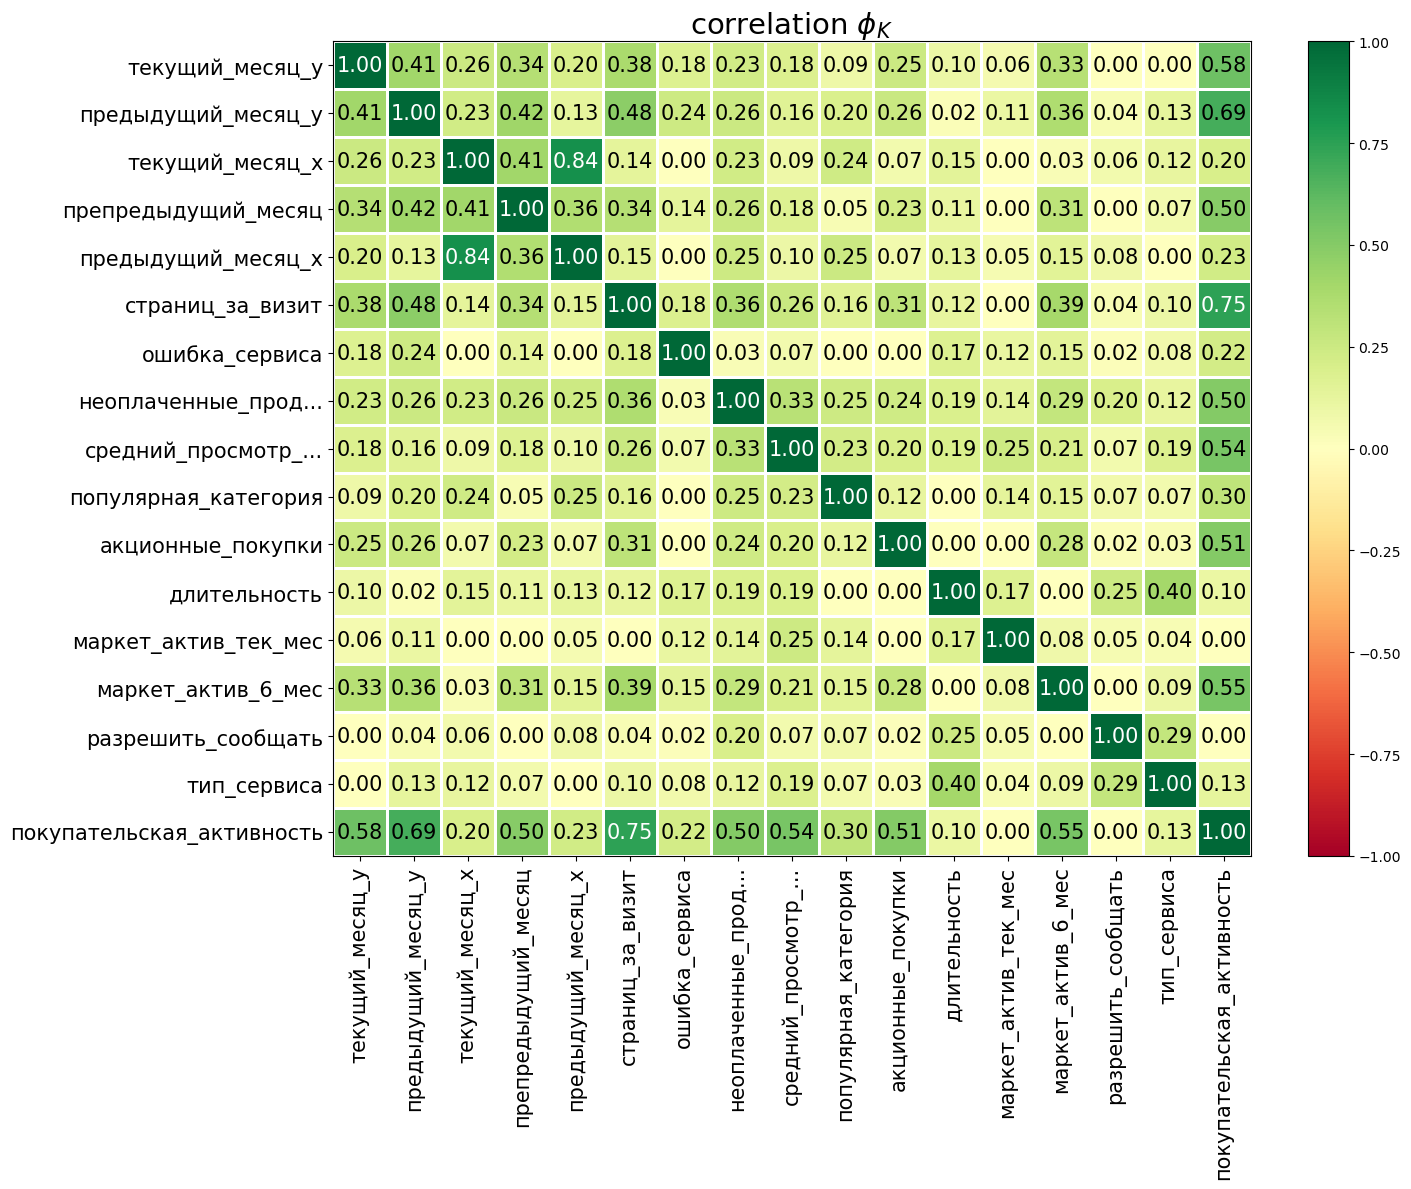

In [117]:
# новый код
plt.rcParams['figure.constrained_layout.use'] = False
# список интервальных признаков
interval_cols = numeric_columns

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = market_data.phik_matrix()

# визуализация тепловой карты коэффициентов корреляции

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    identity_layout=True,
    fontsize_factor=1.5,
    figsize=(15, 12),
    top = 30
    
)


In [118]:
phik_overview.style.background_gradient(cmap='coolwarm')

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
покупательская_активность,1.000000,0.132247,0.000000,0.546370,0.000000,0.101767,0.506991,0.298036,0.539221,0.504845,0.223697,0.748769,0.227280,0.495174,0.195470,0.685078,0.575662
тип_сервиса,0.132247,1.000000,0.286278,0.094182,0.044796,0.401158,0.033339,0.066285,0.186635,0.120842,0.076182,0.100832,0.000000,0.068507,0.123698,0.131084,0.000000
разрешить_сообщать,0.000000,0.286278,1.000000,0.000000,0.051971,0.253956,0.017252,0.071769,0.069322,0.195442,0.020464,0.041128,0.079830,0.000000,0.062923,0.042350,0.000000
маркет_актив_6_мес,0.546370,0.094182,0.000000,1.000000,0.080454,0.000000,0.278729,0.149812,0.205783,0.286304,0.147270,0.394108,0.149129,0.312243,0.032055,0.363780,0.328385
маркет_актив_тек_мес,0.000000,0.044796,0.051971,0.080454,1.000000,0.174385,0.000000,0.136175,0.246726,0.143827,0.116310,0.000000,0.054683,0.000000,0.000000,0.106879,0.062485
длительность,0.101767,0.401158,0.253956,0.000000,0.174385,1.000000,0.000000,0.000000,0.187774,0.191923,0.174467,0.122727,0.125303,0.114058,0.147580,0.024075,0.100502
акционные_покупки,0.506991,0.033339,0.017252,0.278729,0.000000,0.000000,1.000000,0.122840,0.199417,0.237583,0.000000,0.310741,0.065412,0.225681,0.069613,0.262189,0.250014
популярная_категория,0.298036,0.066285,0.071769,0.149812,0.136175,0.000000,0.122840,1.000000,0.225622,0.248558,0.000000,0.160623,0.250974,0.045814,0.237957,0.195219,0.089923
средний_просмотр_категорий_за_визит,0.539221,0.186635,0.069322,0.205783,0.246726,0.187774,0.199417,0.225622,1.000000,0.325688,0.069908,0.262610,0.100332,0.176770,0.092720,0.159393,0.182708
неоплаченные_продукты_штук_квартал,0.504845,0.120842,0.195442,0.286304,0.143827,0.191923,0.237583,0.248558,0.325688,1.000000,0.033392,0.363879,0.249471,0.261530,0.230430,0.255982,0.232121


Анализ полученной таблицы показал, что наибольшая корреляция наблюдается между следующими числовыми признаками:

- `выручка_за_текущий_месяц` vs `выручка_за_предыдущий_месяц`: 0.83;
- `покупательская_активность` vs `страниц_за_визит`: 0.75;
- `покупательская_активность` vs `минут_в_предыдущем_месяце`: 0.69;

Также наблюдаются несколько пар признаков между которыми корреляция находится на уровне 0.3.

### Определение мультиколлинеарности между входными признаками

Расчет мультиколлинеарности проведем с помощью метода `variance_inflation_factor` из библиотеки `statsmodels`.

In [119]:
market_data_mc = market_data[numeric_columns].copy()

list_of_cols = list(market_data_mc.columns)

# формирование переменной formula_like для использования в методе dmatrices
formula_like = []
for el in list_of_cols:
    formula_str = ''
    formula_str = el+' ~ '
    for el2  in list_of_cols:
        if el != el2:
            formula_str = formula_str+'+'+el2
        else:
            continue
    formula_like.append(formula_str)

# в датафрейм vif будем записывать рассчитанные коэффициенты мультиколлинеарности между входными признаками
vif = pd.DataFrame()
for el1, el2 in zip(formula_like, list_of_cols):
    y, X = dmatrices(formula_like=el1, data=market_data_mc, return_type='dataframe')
    vif['VIF_'+el2] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable_'+el2] = X.columns

display(vif)

,VIF_маркет_актив_6_мес,variable_маркет_актив_6_мес,VIF_маркет_актив_тек_мес,variable_маркет_актив_тек_мес,VIF_длительность,variable_длительность,VIF_акционные_покупки,variable_акционные_покупки,VIF_средний_просмотр_категорий_за_визит,variable_средний_просмотр_категорий_за_визит,...,VIF_предыдущий_месяц_x,variable_предыдущий_месяц_x,VIF_препредыдущий_месяц,variable_препредыдущий_месяц,VIF_текущий_месяц_x,variable_текущий_месяц_x,VIF_предыдущий_месяц_y,variable_предыдущий_месяц_y,VIF_текущий_месяц_y,variable_текущий_месяц_y
0,351.37,Intercept,308.33,Intercept,331.65,Intercept,338.92,Intercept,344.27,Intercept,...,341.94,Intercept,153.45,Intercept,327.70,Intercept,352.38,Intercept,352.68,Intercept
1,1.04,маркет_актив_тек_мес,1.21,маркет_актив_6_мес,1.22,маркет_актив_6_мес,1.21,маркет_актив_6_мес,1.21,маркет_актив_6_мес,...,1.22,маркет_актив_6_мес,1.21,маркет_актив_6_мес,1.21,маркет_актив_6_мес,1.21,маркет_актив_6_мес,1.21,маркет_актив_6_мес
2,1.10,длительность,1.08,длительность,1.03,маркет_актив_тек_мес,1.04,маркет_актив_тек_мес,1.04,маркет_актив_тек_мес,...,1.04,маркет_актив_тек_мес,1.04,маркет_актив_тек_мес,1.04,маркет_актив_тек_мес,1.04,маркет_актив_тек_мес,1.04,маркет_актив_тек_мес
3,1.17,акционные_покупки,1.19,акционные_покупки,1.19,акционные_покупки,1.10,длительность,1.09,длительность,...,1.10,длительность,1.10,длительность,1.10,длительность,1.07,длительность,1.08,длительность
4,1.17,средний_просмотр_категорий_за_визит,1.18,средний_просмотр_категорий_за_визит,1.17,средний_просмотр_категорий_за_визит,1.18,средний_просмотр_категорий_за_визит,1.18,акционные_покупки,...,1.19,акционные_покупки,1.18,акционные_покупки,1.19,акционные_покупки,1.17,акционные_покупки,1.18,акционные_покупки
5,1.20,неоплаченные_продукты_штук_квартал,1.20,неоплаченные_продукты_штук_квартал,1.18,неоплаченные_продукты_штук_квартал,1.19,неоплаченные_продукты_штук_квартал,1.14,неоплаченные_продукты_штук_квартал,...,1.18,средний_просмотр_категорий_за_визит,1.18,средний_просмотр_категорий_за_визит,1.18,средний_просмотр_категорий_за_визит,1.17,средний_просмотр_категорий_за_визит,1.16,средний_просмотр_категорий_за_визит
6,1.08,ошибка_сервиса,1.07,ошибка_сервиса,1.06,ошибка_сервиса,1.08,ошибка_сервиса,1.08,ошибка_сервиса,...,1.20,неоплаченные_продукты_штук_квартал,1.16,неоплаченные_продукты_штук_квартал,1.20,неоплаченные_продукты_штук_квартал,1.20,неоплаченные_продукты_штук_квартал,1.20,неоплаченные_продукты_штук_квартал
7,1.39,страниц_за_визит,1.42,страниц_за_визит,1.42,страниц_за_визит,1.38,страниц_за_визит,1.39,страниц_за_визит,...,1.08,ошибка_сервиса,1.08,ошибка_сервиса,1.08,ошибка_сервиса,1.04,ошибка_сервиса,1.08,ошибка_сервиса
8,4.22,предыдущий_месяц_x,4.24,предыдущий_месяц_x,4.24,предыдущий_месяц_x,4.23,предыдущий_месяц_x,4.23,предыдущий_месяц_x,...,1.39,страниц_за_визит,1.39,страниц_за_визит,1.39,страниц_за_визит,1.32,страниц_за_визит,1.41,страниц_за_визит
9,1.60,препредыдущий_месяц,1.61,препредыдущий_месяц,1.61,препредыдущий_месяц,1.61,препредыдущий_месяц,1.61,препредыдущий_месяц,...,1.33,препредыдущий_месяц,3.49,предыдущий_месяц_x,1.20,предыдущий_месяц_x,4.24,предыдущий_месяц_x,4.22,предыдущий_месяц_x


Результат расчетов показал, что максимальное значение VIF не превышает пяти единиц и равно 4.47 между признаками `маркет_актив_тек_мес` и `выручка_за_предыдущий_месяц`. Это означает, что между входными данными не наблюдается сильной мультиколлинеарности.

### Выводы по разделу

Выполнен расчет коэффициентов корреляции между числовыми признаками. Установлено, что максимальная корреляция наблюдается между признаками `выручка_за_текущий_месяц` и `выручка_за_предыдущий_месяц` и составляет 0.83. Расчет мультиколлинеарности методом VIF показал, что сильной мультиколлинеарности между входными данными не просматривается.

## Использование пайплайнов

### Подготовка обучающей и тестовой выборок

Перед созданием пайплайнов подготовим обучающую и тестовую выборки. Также закодируем целевой признак следующим образом: 0 - "Прежний уровень", 1 - "Снизилась".

In [120]:
market_data['покупательская_активность'] = (market_data['покупательская_активность'].where(
    market_data['покупательская_активность']=='Прежний уровень', 0).where(
    market_data['покупательская_активность']=='Снизилась', 1).astype('int'))

In [121]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market_data.drop('покупательская_активность', axis=1),
    market_data['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_data['покупательская_активность']
)

### Создание пайплайнов

Запишем в отдельные переменные названия столбцов с категориальными и количественными переменными.

In [122]:
ohe_columns = [X_train.select_dtypes(exclude='number').columns.tolist()[2]]
ord_columns = X_train.select_dtypes(exclude='number').columns.tolist()[0:2]
num_columns = X_train.select_dtypes(include='number').columns.tolist()

In [123]:
ohe_columns

['популярная_категория']

In [124]:
# OHE-кодирование в пайплайне
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
) 


# ORD-кодирование в пайплайне
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['нет', 'да']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# Запишем в пайплайн `data_preprocessor` шаги по кодированию и масштабированию исходных данных

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Итоговый пайплайн

pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

# Словарь для перебора методов масштабирования и моделей:

param_grid = {
    'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler(), 
        RobustScaler(), 
        'passthrough'
    ],
    'models' : [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE),
        LogisticRegression(random_state=RANDOM_STATE)]
}

# Список словарей для перебора методов масштабирования и моделей и их гиперпараметров:

param_distributions = [ 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

In [125]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   O...
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'предыдущий_месяц_x',
                                                   'препредыдущий_месяц',
                                                   'текущий_месяц_x',
                                                   'предыдущий_месяц_y',
                                                   'текущий_месяц_y'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

Выполним перебор методов масштабирования и моделей с помощью `RandomizedSearchCV`. В качестве метрики будем использовать roc_auc, так как данная метрика позволяет оценить качество работы модели вне зависимости от выбранного порога вероятности.

In [126]:
# новый код
simplefilter(action='ignore', category=FutureWarning)

In [127]:
X_train

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
id,,,,,,,,,,,,,,,,
215775,стандарт,нет,5.00,4,157,0.15,Мелкая бытовая техника и электроника,5,0,5,13,"4,028.00","4,934.00","3,372.80",19,16
215851,стандарт,да,4.10,4,530,0.26,Домашний текстиль,2,5,4,13,"4,903.50","5,316.00","4,676.00",17,11
215375,премиум,да,3.00,4,558,0.89,Товары для детей,3,3,7,4,"5,253.50","4,715.00","5,633.10",8,9
215389,премиум,да,4.10,3,1047,0.93,Товары для детей,5,2,3,7,"4,550.00","4,484.00","4,429.10",7,7
216646,стандарт,да,6.30,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,"4,923.00","4,725.00","5,224.60",18,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215833,стандарт,да,4.80,4,410,0.17,Домашний текстиль,6,2,7,9,"5,919.00","5,204.00","5,428.90",14,19
216088,стандарт,нет,4.70,4,946,0.18,Косметика и аксесуары,3,1,4,9,"5,137.50","5,235.00","5,183.00",15,21
215986,стандарт,да,4.90,4,203,0.11,Товары для детей,5,2,4,14,"5,296.00","5,305.00","5,433.80",17,10


In [128]:
y_train

id
215775    1
215851    1
215375    0
215389    0
216646    1
         ..
215833    0
216088    1
215986    1
215813    0
215678    0
Name: покупательская_активность, Length: 972, dtype: int32

In [129]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
               

Выведем датафрейм с описанием найденных моделей, которые лучше всего подбирают решение.

In [130]:
result = pd.DataFrame(randomized_search.cv_results_)
pd.set_option('display.max_colwidth', 255)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params
0,1,"SVC(C=1, probability=True, random_state=42)",0.91,"{'preprocessor__num': StandardScaler(), 'models__C': 1, 'models': SVC(C=1, probability=True, random_state=42)}"
8,2,LogisticRegression(random_state=42),0.91,"{'preprocessor__num': StandardScaler(), 'models__C': 1, 'models': LogisticRegression(random_state=42)}"
5,3,LogisticRegression(random_state=42),0.91,"{'preprocessor__num': StandardScaler(), 'models__C': 3, 'models': LogisticRegression(random_state=42)}"
2,4,"SVC(C=1, probability=True, random_state=42)",0.90,"{'preprocessor__num': MinMaxScaler(), 'models__C': 1, 'models': SVC(C=1, probability=True, random_state=42)}"
6,5,"SVC(C=1, probability=True, random_state=42)",0.90,"{'preprocessor__num': MinMaxScaler(), 'models__C': 4, 'models': SVC(C=1, probability=True, random_state=42)}"
9,6,DecisionTreeClassifier(random_state=42),0.87,"{'preprocessor__num': 'passthrough', 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
3,7,DecisionTreeClassifier(random_state=42),0.85,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
1,8,DecisionTreeClassifier(random_state=42),0.84,"{'preprocessor__num': MinMaxScaler(), 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
4,9,DecisionTreeClassifier(random_state=42),0.84,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
7,10,DecisionTreeClassifier(random_state=42),0.83,"{'preprocessor__num': MinMaxScaler(), 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=42)}"


Выполним расчет метрики на тестовой выборке:

In [131]:
y_test_pred = randomized_search.predict(X_test)
# новый код
y_test_pred_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9058738565238325


### Выводы по разделу

Использование общего пайплайна показало, что наилучшей моделью является `KNeighborsClassifier()` с гиперпараметром `models__n_neighbors`=~~12~~16 и масштабированием `StandardScaler()`. На обучающих данных метрика ROC-AUC для данной модели составила 0.907, на тестовых данных 0.885.

## Анализ важности признаков

Перед выполнением данного анализа необходимо подготовить исходные данные и инициализировать лучшую модель.

### Подготовка данных

Выполним подготовку данных с помощью функции `prepare_data`. В качестве входных параметров укажем уже созданные ранее выборки `X_train`, `X_test`, метод масштабирования `StandardScaler()` и кодировщик `OneHotEncoder()` с параметрами `sparse=False`, `drop='first'`. Также убедимся, что созданная модель дает такое же значение метрики ROC-AUC, что и полученная ранее с помощью пайплайна.

In [132]:
# новый код
best_model = randomized_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   O...
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'предыдущий_месяц_x',
                                                   'препредыдущий_месяц',
                                                   'текущий_месяц_x',
                                                   'предыдущий_месяц_y',
                                                   'текущий_месяц_y'])])),
                ('models', SVC(C=1, probability=True, random_state=42))])

In [133]:
# новый код
X_train_2 = best_model[0].transform(X_train) 
X_test_2 = best_model[0].transform(X_test)
y_pred = best_model[1].predict(X_test_2)
y_pred_proba = best_model[1].predict_proba(X_test_2)
roc = roc_auc_score(y_test, y_pred) # расчет и вывод метрики roc-auc
print('ROC-AUC =', round(roc,4))
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba[:,1])}')

ROC-AUC = 0.848
Метрика ROC-AUC на тестовой выборке: 0.9058738565238325


In [134]:
# старый код
#X_train_2, X_test_2 = prepare_data(X_train, X_test) # подготвовка данных
#best_model = KNeighborsClassifier(n_neighbors=12) # инициализация модели
#best_model.fit(X_train_2, y_train) # обучение модели на тренировочных данных
#y_pred = best_model.predict(X_test_2) # предсказание на тестовых данных
#y_pred_proba = best_model.predict_proba(X_test_2) # вероятность отнесения тестовых данных к классам 0 и 1
#roc = roc_auc_score(y_test, y_pred) # расчет и вывод метрики roc-auc
#print('ROC-AUC =', round(roc,4))


### Расчет важности признаков

Из-за большого числа исходных данных методу `KernelExplainer` передадим выборку, состоящую из 80 строк, так как при полном наборе расчет занимает очень длительное время.

In [135]:
# новый код
X_train_2 = pd.DataFrame(X_train_2, columns=best_model[0].get_feature_names_out())

In [140]:
X_train_2_shap = X_train_2.sample(10, random_state=RANDOM_STATE)

explainer = shap.KernelExplainer(best_model[1].predict_proba, X_train_2_shap)

shap_values = explainer(X_train_2_shap)

  0%|          | 0/10 [00:00<?, ?it/s]

График вклада признаков в каждое предсказание модели

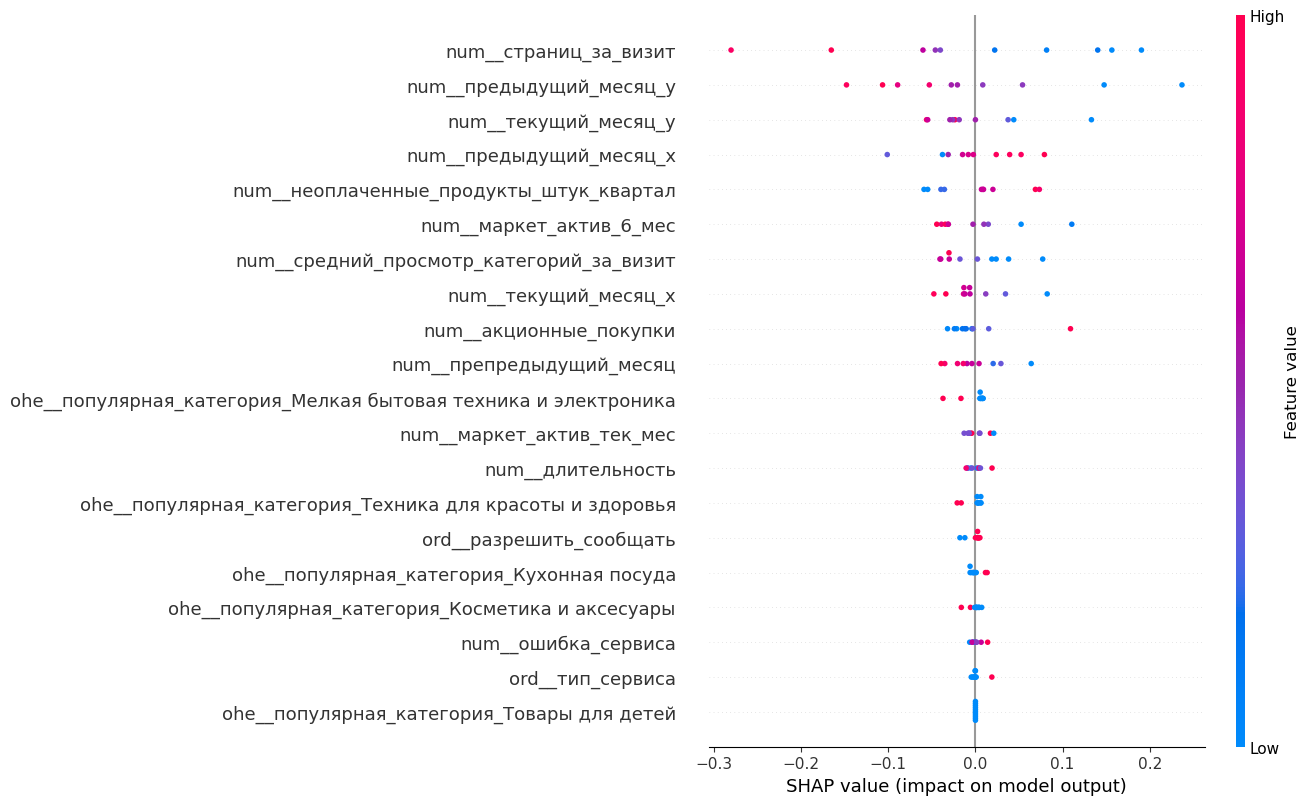

In [141]:
shap.plots.beeswarm(shap_values[:,:,0], max_display=20)

### Выводы по разделу

Из анализа графика важности признаков можно сделать следующие выводы:

- наибольшее влияние на результат предсказания оказывает признак `минут_в_текущем_месяце` - чем выше значение признака, тем сильнее вероятность отнесения клиента к классу 0 - "Прежний уровень", чем ниже значение признака, тем выше вероятность отнесения клиента к классу 1 - "Снизилась";
- аналогичный вывод применим к признакам `страниц_за_визит` и `минут_в_предыдущем_месяце`;
- признак `акционные покупки` показал интересный и ожидаемый результат - если доля акционных покупок низкая, то на результат предсказания данный признак не оказывает сильного влияния. Однако, если доля таких покупок высокая, то с большей вероятностью модель отнесет таких клиентов к классу 1 - "Снизилась";
- признаки `маркет_актив_6_мес`, `выручка_за_препредыдущий_месяц`, `средний_просмотр_категорий_за_визит` оказывают похожее влияние на результат предсказания, как и первые три признака (`минут_в_текущем_месяце`, `страниц_за_визит` и `минут_в_предыдущем_месяце`), но в меньшей степени;
- признак `неоплаченные_продукты_штук_квартал` влияет на результат примерно также, как и признак `акционные покупки`, но в меньшей степени;
- остальные признаки имеют меньшее влияние на результат  предсказания модели.


## Сегментация покупателей

### Подготовка данных перед сегментацией
Перед выполнением сегментации добавим к датафреймам `X_train_2`, `X_test_2` столбец `id` из датафреймов `X_train`, `X_test` соответственно. Затем добавим к ним столбец `прибыль` из датафрейма `money`. Ключевым полем выступит `id`. Также к каждому получившемуся датафрейму добавим результаты метода `predict_proba`. Оба датафрейма объединим в один `X_seg`.

In [142]:
money = money.set_index('id') # изначально в датафрейме money не было поля 'id' - исправим это

In [143]:
# новый код - преобразование массива в формат dataframe
X_test_2 = pd.DataFrame(X_test_2, columns=best_model[0].get_feature_names_out())

In [144]:
# работаем с копиями датафреймов
X_train_2_seg = X_train_2.copy()
X_test_2_seg = X_test_2.copy()

# добавляем столбец id
X_train_2_seg['id'] = X_train.index
X_test_2_seg['id'] = X_test.index

# добавляем столбец прибыль
X_train_2_seg = pd.merge(X_train_2_seg, money, left_on='id', right_on='id')
X_test_2_seg = pd.merge(X_test_2_seg, money, left_on='id', right_on='id')

# добавляем вероятности
X_train_2_seg['predict_proba'] = best_model[1].predict_proba(X_train_2)[:,1]
X_test_2_seg['predict_proba'] = best_model[1].predict_proba(X_test_2)[:,1]

# объединяем датафреймы
X_seg = pd.concat([X_train_2_seg, X_test_2_seg]).reset_index(drop=True)

C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


### Выполнение сегментации по различным признакам

Выполним сегментацию покупателей по признакам `минут_в_текущем_месяце`, `страниц_за_визит`, `минут_в_предыдущем_месяце`, так как данные признаки являются наиболее влияющим при определении прогноза (раздел 8). Сперва определим основные статистические характеристики данного распределения.

In [145]:
features = ['num__длительность']
X_seg[features].describe()

,num__длительность
count,"1,297.00"
mean,0.02
std,1.01
min,-1.94
25%,-0.76
50%,0.04
75%,0.85
max,1.95


Исходя из графика важности признаков и статистических характеристик, можно установить примерную границу на уровне среднего значения каждого признака, по которой выполним сегментацию покупателей. После этого необходимо выбрать группу, у которой значения признаков оказались ниже среднего (такие покупатели скорее всего будут отнесены к классу 1 - "Снизилась").

In [146]:
X_seg_group = X_seg.query('num__длительность > 1.5')
print(f'Количество клиентов в выборке: {X_seg_group.shape[0]}')

Количество клиентов в выборке: 97


### Анализ отобранной группы пользователей

Для анализа отобранной группы пользователей построим график распределения прибыли от вероятности снижения покупательской активности.

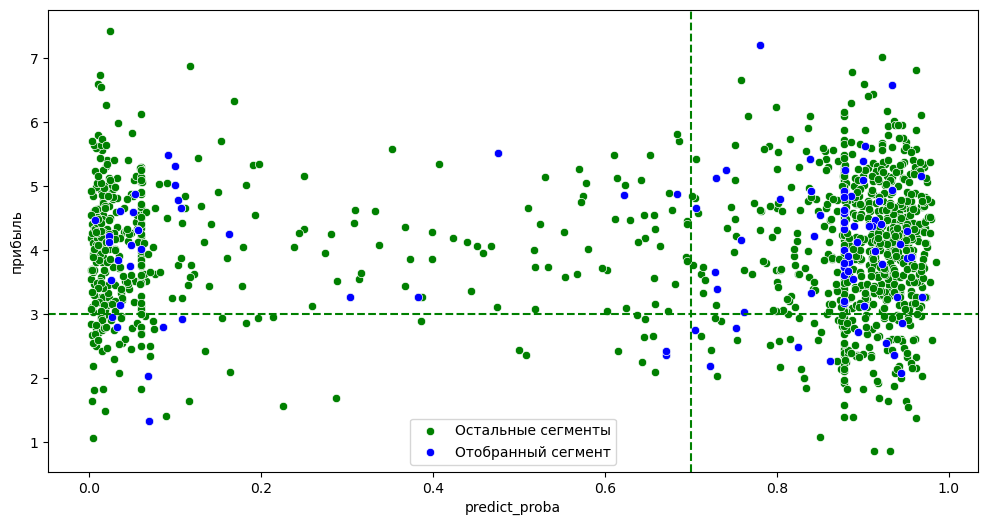

In [147]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=X_seg, x='predict_proba', y='прибыль', label='Остальные сегменты', color='green')
sns.scatterplot(data=X_seg_group, x='predict_proba', y='прибыль', label='Отобранный сегмент', color='blue')
plt.axvline(x=0.7, color='green', linestyle='--')
plt.axhline(y=3, color='green', linestyle='--')
plt.legend()
plt.show()

### Выводы по разделу

При уменьшении времени нахождения на сайте а также числа просмотренных страниц вероятность снижения покупательской способности возрастает. Таким образом, необходимо увеличить среднее время нахождения пользователей на сайте, а также обеспечить росто числа просмотренных страниц.

Данного результата можно добиться путем улучшения внешнего вида (т.е. привлекательности) сайта, удобства его использования, увеличения числа предлагаемых к просмотру товаров.

## Общий вывод

В данном проекте требовалось определить способ повышения покупательской способности клиентов интернет-магазина "В один клик".

Исходные данные состояли из четырех таблиц и содержали данные о 1300 клиентах. На этапе предобработки были исправлены выявленные неявные дубликаты.

С помощью пайплайнов была найдена наилучшая модель - `KNeighborsClassifier()` с гиперпараметром `models__n_neighbors`=12 и масштабированием `StandardScaler()`. На обучающих данных метрика ROC-AUC для данной модели составила 0.918, на тестовых данных 0.835.

Анализ работы модели показал, что наиболее сильно на снижение покупательской активности влияют следующие признаки: `минут_в_текущем_месяце`, `страниц_за_визит`, `минут_в_предыдущем_месяце`. Уменьшение их значений увеличивает вероятность снижения покупательской активности. В качестве решения проблемы предложены следующие решения: 
- провести улучшение внешнего вида (т.е. привлекательности) сайта;
- улучшить интерфейс и удобство его использования;
- увеличить число предлагаемых к просмотру товаров.